In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import metpy as mp
from metpy.units import units
import metpy.calc as mpc
import Ngl

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util


In [2]:
# - - - - - - - - - - - - - - - 
# Regrid utility 
# - - - - - - - - - - - - - - - 
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result


## Looking at surface properties in Surface Dataset

In [3]:
# Open surface data file
surfDat = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc'
surfDS = xr.open_dataset(surfDat)


In [4]:
# Pick out a few values - lat, lon,  
lsmlat = surfDS.LATIXY.values
lsmlon = surfDS.LONGXY.values

# Assign those as indices in the DS
surfDS = surfDS.assign_coords(lsmlon= np.sort(np.unique(lsmlon)))
surfDS = surfDS.assign_coords(lsmlat= np.sort(np.unique(lsmlat)))

# Indices of natural PFTs and crop PFTs (CFTs)
natpft = surfDS.natpft.values
cft    = surfDS.cft.values


In [20]:
mask = surfDS.LANDFRAC_PFT.values
mask[np.where(mask<=0.2)] = np.nan

In [22]:
surfDS

<xarray.Dataset>
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lsmlon                   (lsmlon) float64 0.0 1.25 2.5 ... 356.2 357.5 358.7
  * lsmlat                   (lsmlat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
Dimensions without coordinates: nlevsoi, lsmpft, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 ...
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 ...
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 ...
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 ...
    FMAX                     (lsmlat, lsmlon) float64 ...
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 ...
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 ...
    CONST_GRAZING            (lsmlat, lsmlon) float64 ...
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 ...
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 ...
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 ...
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

In [5]:
# Use ARM SGP site for example
selLon = 262.5
selLat = 36.6


In [6]:
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

Text(0.5, 1.0, 'Organic Matter Density @ nlev = 2')

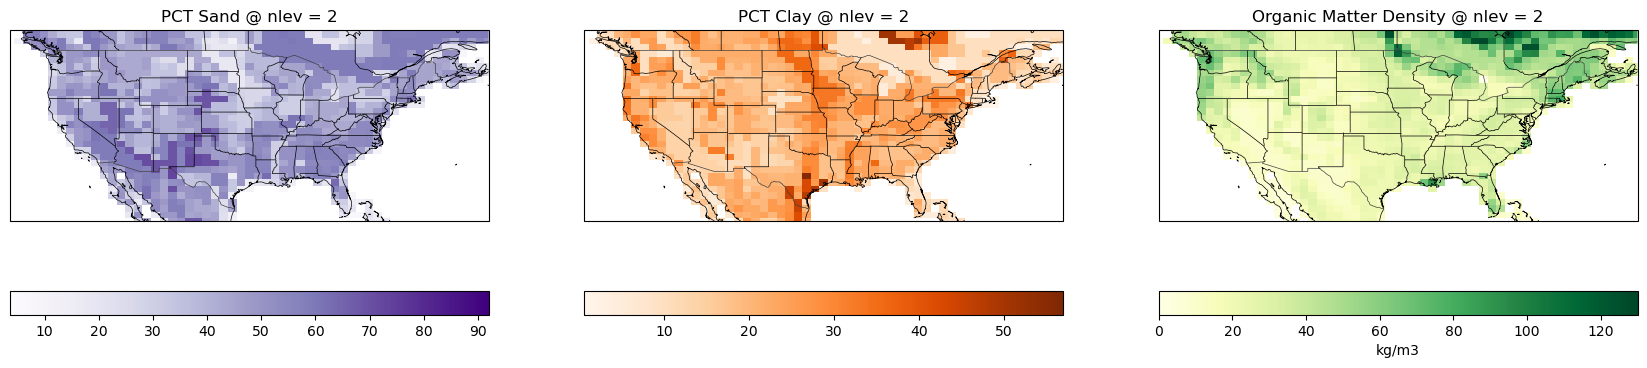

In [28]:
fig, axs = plt.subplots(1,3, figsize=(21, 6), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

inlev = 2

## Set up the map with boundaries, limited extent, etc.
# [a.set_extent([-110,-80,30,40], crs=ccrs.PlateCarree()) for a in axs]
[a.set_extent([-130,-60,24,52], crs=ccrs.PlateCarree()) for a in axs]

[a.coastlines(linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

## Add plot of PCT_NATVEG (percentage of each gridcell that's naturally vegetated)
cplot = axs[0].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_SAND.isel(nlevsoi=inlev).values, cmap='Purples')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[0].set_title('PCT Sand @ nlev = '+str(inlev))

## Add plot of PCT_NATVEG (percentage of each gridcell that's naturally vegetated)
cplot = axs[1].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_CLAY.isel(nlevsoi=inlev).values, cmap='Oranges')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[1].set_title('PCT Clay @ nlev = '+ str(inlev))

## Add plot of PCT_NATVEG (percentage of each gridcell that's naturally vegetated)
cplot = axs[2].pcolormesh(lsmlon,lsmlat, mask * surfDS.ORGANIC.isel(nlevsoi=inlev).values, cmap='YlGn')
cbar  = plt.colorbar(cplot, orientation='horizontal', label='kg/m3')
axs[2].set_title('Organic Matter Density @ nlev = '+ str(inlev))

# Add point for ARM site 
# [a.plot(selLon,selLat,'o',markerfacecolor='r',transform=ccrs.PlateCarree()) for a in axs]


Text(0.5, 1.0, 'PCT Lake')

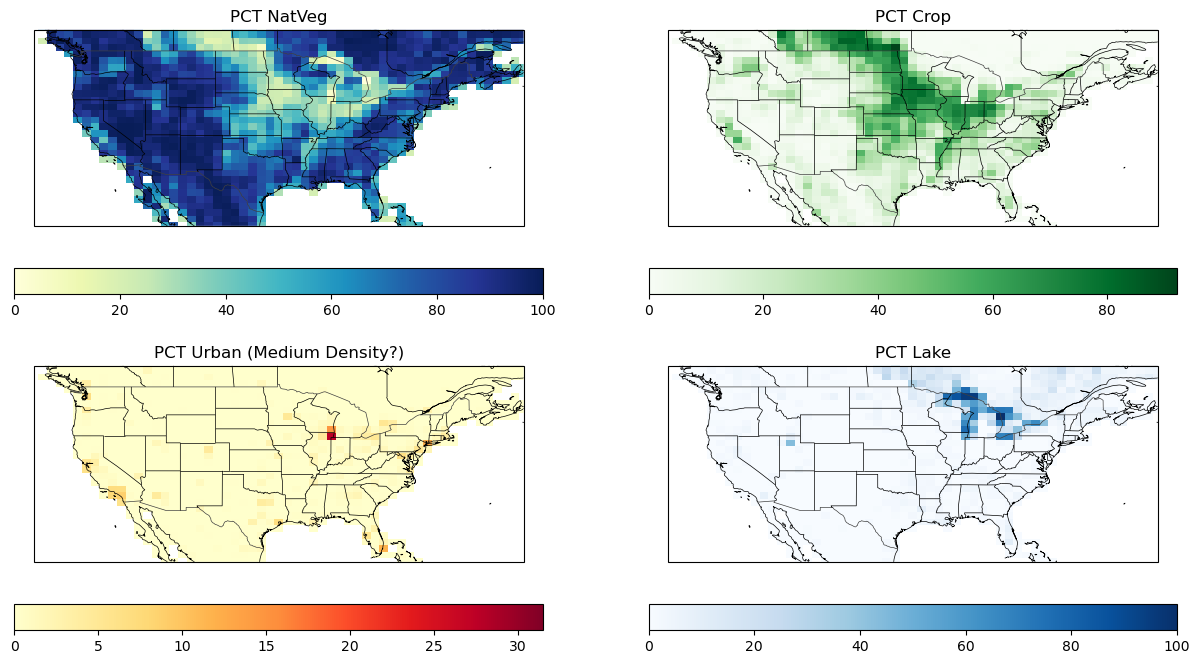

In [37]:
fig, axs = plt.subplots(2,2, figsize=(15, 8), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

## Set up the map with boundaries, limited extent, etc.
# [a.set_extent([-110,-80,30,40], crs=ccrs.PlateCarree()) for a in axs]
[a.set_extent([-130,-60,24,52], crs=ccrs.PlateCarree()) for a in axs]

[a.coastlines(linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

## Add plot of PCT_NATVEG (percentage of each gridcell that's naturally vegetated)
cplot = axs[0].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_NATVEG.values, cmap='YlGnBu')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[0].set_title('PCT NatVeg')

cplot = axs[1].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_CROP.values, cmap='Greens')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[1].set_title('PCT Crop')

cplot = axs[2].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_URBAN.values[2,:,:], cmap='YlOrRd')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[2].set_title('PCT Urban (Medium Density?)')

cplot = axs[3].pcolormesh(lsmlon,lsmlat, mask * surfDS.PCT_LAKE.values, cmap='Blues')
cbar  = plt.colorbar(cplot, orientation='horizontal')
axs[3].set_title('PCT Lake')

# Add point for ARM site 
# [a.plot(selLon,selLat,'o',markerfacecolor='r',transform=ccrs.PlateCarree()) for a in axs]


In [135]:
## Specific info for selected site 
surfDS_site = surfDS.sel(lsmlat=selLat, lsmlon=selLon, method='nearest')

print('At this site ...')
print('Requested:  Lat = %9.3f   Lon = %9.3f' % (selLat, selLon))
print('Retrieved:  Lat = %9.3f   Lon = %9.3f' % (surfDS_site.lsmlat.values, surfDS_site.lsmlon.values))
print()
print('Soil composition (at first level) \nPctClay = %12.3f\nPctSand = %12.3f\n' % (surfDS_site.PCT_SAND.values[0], surfDS_site.PCT_CLAY.values[0]) )
print('Surface cover\nPct_nat_veg = %9.3f\nPct_crop = %12.3f\n' % (surfDS_site.PCT_NATVEG.values, surfDS_site.PCT_CROP.values) )
print('PFT_identifier   Percentage (of PCT_NAT_VEG)')
for iPFT in range(len(surfDS_site.natpft.values)): 
    print('%8i %15.3f' % (surfDS_site.natpft.values[iPFT], surfDS_site.PCT_NAT_PFT.values[iPFT]) )

print('\ncrop_identifier   Percentage (of PCT_CROP)')
for iPFT in range(len(surfDS_site.cft.values)): 
    print('%8i %15.3f' % (surfDS_site.cft.values[iPFT], surfDS_site.PCT_CFT.values[iPFT]) )

At this site ...
Requested:  Lat =    36.600   Lon =   262.500
Retrieved:  Lat =    36.283   Lon =   262.500

Soil composition (at first level) 
PctClay =       37.000
PctSand =       23.000

Surface cover
Pct_nat_veg =    45.365
Pct_crop =       54.529

PFT_identifier   Percentage
       0           0.000
       1           1.445
       2           0.000
       3           0.000
       4           0.000
       5           0.000
       6           0.000
       7           2.175
       8           0.000
       9           0.000
      10           0.000
      11           0.000
      12           0.000
      13          52.638
      14          43.741

crop_identifier   Percentage
      15         100.000
      16           0.000


Data decoder (from cesm_2.1.3/components/clm/src/main/PatchType.F90)
<br>
 <br>
DESCRIPTION: <br>
Patch data type allocation  <br>
patch types can have values of <br>
- 0  => not_vegetated <br>
- 1  => needleleaf_evergreen_temperate_tree <br>
- 2  => needleleaf_evergreen_boreal_tree <br>
- 3  => needleleaf_deciduous_boreal_tree <br>
- 4  => broadleaf_evergreen_tropical_tree <br>
- 5  => broadleaf_evergreen_temperate_tree <br>
- 6  => broadleaf_deciduous_tropical_tree <br>
- 7  => broadleaf_deciduous_temperate_tree <br>
- 8  => broadleaf_deciduous_boreal_tree <br>
- 9  => broadleaf_evergreen_shrub <br>
- 10 => broadleaf_deciduous_temperate_shrub <br>
- 11 => broadleaf_deciduous_boreal_shrub <br>
- 12 => c3_arctic_grass <br>
- 13 => c3_non-arctic_grass <br>
- 14 => c4_grass <br>
- 15 => c3_crop <br>
- 16 => c3_irrigated <br>

In [136]:
!pwd

/glade/u/home/mdfowler/Analysis


## Sanity check: Do the variables in CAM history files match the variables in CLM history files?

In [3]:
caseNames = ['f.e21.F2000climo.f09_f09_mg17.S2S_LandAtmCoupling_output.002']

case_IDs = ['F2000climo_ctrl']

dataDir = '/glade/campaign/cgd/tss/people/mdfowler/LandAtmCoupling_longRuns/'

In [9]:
## Select files 
listFiles_atm = np.sort(glob.glob(dataDir+caseNames[0]+'/atm/hist/*cam.h0.????-*'))
listFiles_lnd = np.sort(glob.glob(dataDir+caseNames[0]+'/lnd/hist/*clm2.h0.????-*'))

atmDS = xr.open_dataset(listFiles_atm[1])
lndDS = xr.open_dataset(listFiles_lnd[1])


In [137]:
print(atmDS.time.values)
print(lndDS.time.values)

[cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, has_year_zero=True)]


In [ ]:
# Fun - the lat values are just slightly different between atm and land history fields
# So let's regrid 
targetGrid = atmDS['LHFLX'].load().squeeze()
lndDS      = regrid_data(lndDS, targetGrid, method=1)

# number of lat and lon points (makes life easier)
nLat = len(atmDS.lat.values)
nLon = len(atmDS.lon.values)

# Define a land mask (values should only match where 100% land
landMask = np.full([nLat, nLon], np.nan)
landMask[np.where(np.squeeze(lndDS.landfrac.values)==1)] = 1


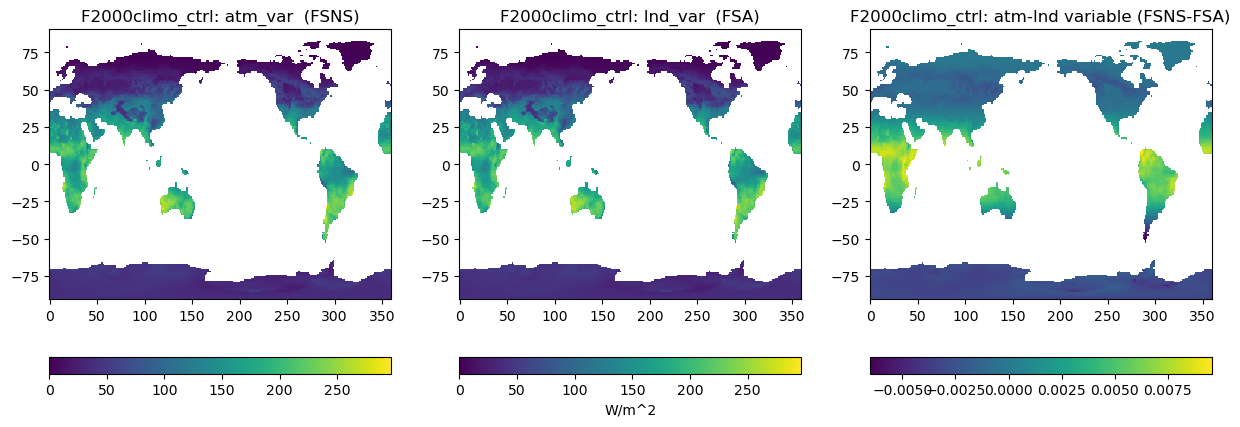

In [139]:
atmVar = 'FSNS'
lndVar =  'FSA'

diffVar = atmDS[atmVar] - lndDS[lndVar]

fig,axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()


p1 = axs[0].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*atmDS[atmVar].values))
axs[0].set_title(case_IDs[0]+': atm_var  ('+atmVar+')')
fig.colorbar(p1,orientation='horizontal')

p2 = axs[1].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*lndDS[lndVar].values))
axs[1].set_title(case_IDs[0]+': lnd_var  ('+lndVar+')')
fig.colorbar(p2,orientation='horizontal', label=lndDS[lndVar].units)

p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values))  ## Use this for raw difference 
# p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values)/np.squeeze(lndDS[lndVar].values)*100) ## Use this for percent difference
axs[2].set_title(case_IDs[0]+': atm-lnd variable ('+atmVar+'-'+lndVar+')')
fig.colorbar(p3,orientation='horizontal')


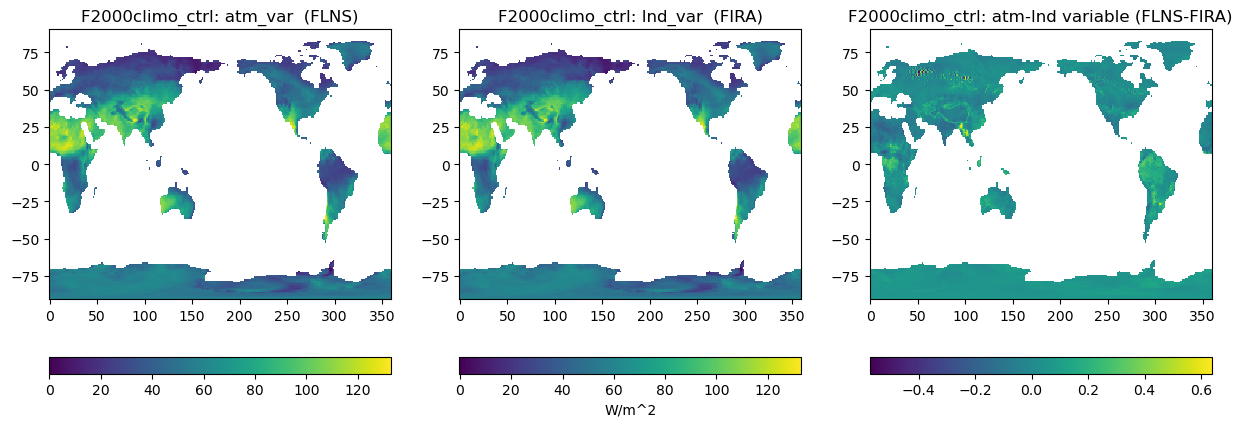

In [138]:
atmVar = 'FLNS'
lndVar =  'FIRA'

diffVar = atmDS[atmVar] - lndDS[lndVar]

fig,axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()


p1 = axs[0].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*atmDS[atmVar].values))
axs[0].set_title(case_IDs[0]+': atm_var  ('+atmVar+')')
fig.colorbar(p1,orientation='horizontal')

p2 = axs[1].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*lndDS[lndVar].values))
axs[1].set_title(case_IDs[0]+': lnd_var  ('+lndVar+')')
fig.colorbar(p2,orientation='horizontal', label=lndDS[lndVar].units)

p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values))
# p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values)/np.squeeze(lndDS[lndVar].values)*100)  ## Use this for percent difference
axs[2].set_title(case_IDs[0]+': atm-lnd variable ('+atmVar+'-'+lndVar+')')
fig.colorbar(p3,orientation='horizontal')


In [ ]:
atmVar = 'FLNS'
lndVar =  'FIRA'

diffVar = atmDS[atmVar] - lndDS[lndVar]

fig,axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.ravel()


p1 = axs[0].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*atmDS[atmVar].values))
axs[0].set_title(case_IDs[0]+': atm_var  ('+atmVar+')')
fig.colorbar(p1,orientation='horizontal')

p2 = axs[1].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*lndDS[lndVar].values))
axs[1].set_title(case_IDs[0]+': lnd_var  ('+lndVar+')')
fig.colorbar(p2,orientation='horizontal')

p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values))
# p3 = axs[2].pcolormesh(diffVar.lon.values, diffVar.lat.values, np.squeeze(landMask*diffVar.values)/np.squeeze(lndDS[lndVar].values)*100)  ## Use this for percent difference
axs[2].set_title(case_IDs[0]+': atm-lnd variable ('+atmVar+'-'+lndVar+')')
fig.colorbar(p3,orientation='horizontal')
